In [252]:
import lsst.afw.detection as afwDet
import lsst.afw.table as afwTable
import lsst.meas.algorithms.detection as detection
import lsst.afw.image as afwImage
import lsst.afw.display as afwDisplay
import matplotlib.pyplot as plt
import astropy.table
import lsst.geom
from time import time

In [63]:
afwDisplay.setDefaultBackend("matplotlib")

In [3]:
import logging
logging.basicConfig()
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logger.info("test")

INFO:root:test


In [183]:
config = detection.SourceDetectionConfig()
config.excludeMaskPlanes = [
    "EDGE",
    "SAT",
    "SUSPECT",
    "BAD",
    "NO_DATA",
    "STREAK"
]
config.thresholdValue = 3
task = detection.SourceDetectionTask(config=config)

table = afwTable.SourceTable.makeMinimalSchema()
t1 = time()
reader = afwImage.ExposureFitsReader(
    "../data/differenceExp_DECam_VR_VR_DECam_c0007_6300_0_2600_0_845685_N15_DEEP_20190402_A0a_scienceHASHstep6_20240404T235221Z.fits"
)
exposure = reader.read()
exposure_date = exposure.visitInfo.getDate()
half = (exposure.visitInfo.getExposureTime() / 2 + 1/2) / (24*60*60)
exposure_date_jd = exposure_date.get(exposure_date.JD) + half
wcs = exposure.wcs
point_to_sphere = wcs.getTransform().applyForward

t2 = time()
results = task.run(table, exposure)
t3 = time()

footprintSet = results.positive
footprints = footprintSet.getFootprints()
peaks = []
for footprint in footprints:
    peaks.append(footprint.peaks.asAstropy())
peaks = astropy.table.vstack(peaks)
t4 = time()
coords = [point_to_sphere(lsst.geom.Point2D(_x, _y)) for _x, _y in zip(peaks['i_x'], peaks['i_y'])]
ra = [float(c.getRa()) for c in coords]
dec = [float(c.getDec()) for c in coords]
peaks['ra'] = ra
peaks['dec'] = dec
t5 = time()

print("read:", t2 - t1)
print("run:", t3 - t2)
print("astropy:", t4 - t3)
print("ra/dec:", t5 - t4)

INFO:lsst.sourceDetection:Setting factor for negative detections equal to that for positive detections: 1.000000
INFO:lsst.sourceDetection:Detected 556 positive peaks in 514 footprints and 612 negative peaks in 540 footprints to 3 +ve and 3 -ve sigma
INFO:lsst.sourceDetection:Resubtracting the background after object detection


read: 0.8072474002838135
run: 2.148991346359253
table: 0.784895658493042
ra/dec: 0.01508641242980957


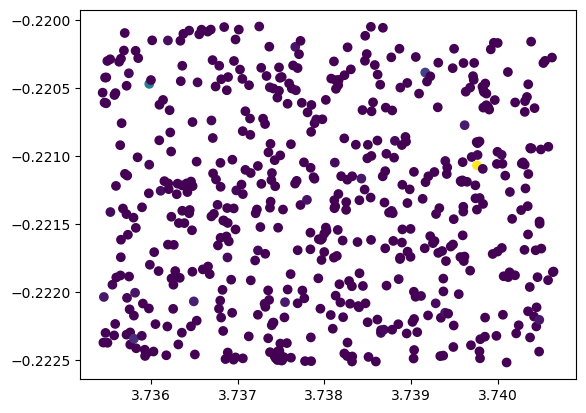

In [185]:
plt.scatter(peaks['ra'], peaks['dec'], c=peaks['significance'])
plt.show()

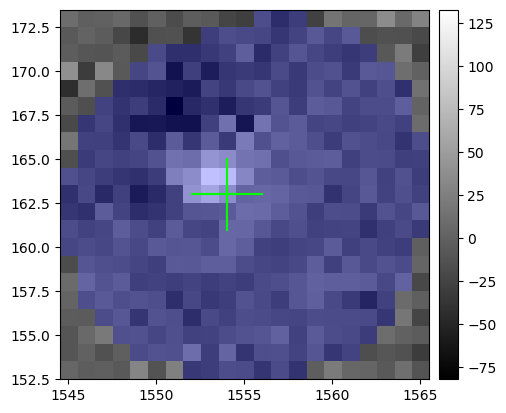

In [188]:
footprint = footprints[10]
fig = plt.figure()
display = afwDisplay.Display(frame=fig)
display.mtv(exposure.getCutout(footprint.getBBox()))
for peak in footprint.peaks:
    display.dot("+", peak['i_x'], peak['i_y'])

Struct(posCentroidX=1846.767926530529; posCentroidY=180.5256636071157; negCentroidX=1847.14049385778; negCentroidY=181.0431837443003; posFlux=5776.472067653581; negFlux=-4702.672559160578; posFluxErr=None; negFluxErr=None; centroidX=1846.9542101941545; centroidY=180.784423675708; orientation=-125.75044765521243; signalToNoise=23.48027901426502; chi2=107758.46892047526; redChi2=274.19457740578946; nData=399)
393.0 1.0


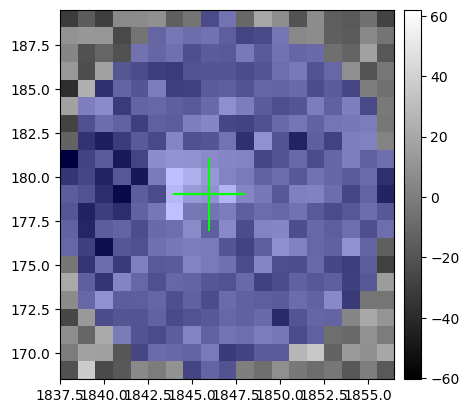

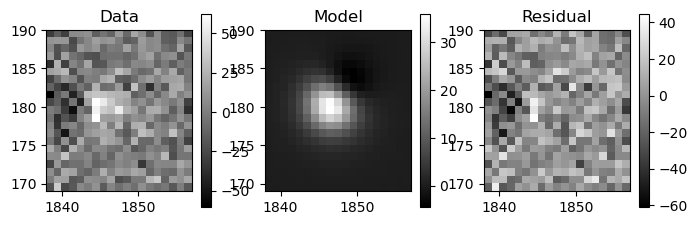

In [251]:
from scipy.stats import chi2

i = 11

source = results.sources[i]
footprint = source.getFootprint()

fig = plt.figure()
display = afwDisplay.Display(frame=fig)
display.mtv(exposure.getCutout(footprint.getBBox()))
for peak in footprint.peaks:
    display.dot("+", peak['i_x'], peak['i_y'])

alg = ipDiffim.DipoleFitAlgorithm(exposure)
fitDipoleResult, fitDipoleModel = alg.fitDipole(results.sources[i], display=True)
print(fitDipoleResult)
ndof = fitDipoleResult.chi2 / fitDipoleResult.redChi2
significance = chi2.cdf(fitDipoleResult.chi2, ndof)
print(ndof, significance)

In [230]:
ipDiffim.DipoleFitAlgorithm.fitDipole(results.sources[0])

TypeError: DipoleFitAlgorithm.fitDipole() missing 1 required positional argument: 'source'

In [223]:
import numpy as np

for s in results.sources:
    _peaks = s.getFootprint().getPeaks()
    n_peaks = len(_peaks)
    if n_peaks > 1:
        n_pos = (np.sign(_peaks['peakValue']) == 1).sum()
        n_neg = (np.sign(_peaks['peakValue']) == -1).sum()
        if n_pos != n_peaks:
            print(s)
            break
    
# results.sources[0].getFootprint().getPeaks()

In [216]:
ipDiffim.DipoleDeblender()(results.sources[3], exposure)

INFO:lsst.ip.diffim.DipoleDeblender:deblended.centroid.dipole.psf.pos 508.000000 105.000000
INFO:lsst.ip.diffim.DipoleDeblender:deblended.chi2dof.dipole.pos 3.073072
INFO:lsst.ip.diffim.DipoleDeblender:deblended.flux.dipole.psf.pos 1619382.929009
INFO:lsst.ip.diffim.DipoleDeblender:deblended.centroid.dipole.psf.pos 504.000000 91.000000
INFO:lsst.ip.diffim.DipoleDeblender:deblended.chi2dof.dipole.pos 4.622071
INFO:lsst.ip.diffim.DipoleDeblender:deblended.flux.dipole.psf.pos 3470910.552058


<class 'lsst.afw.table.SourceRecord'>
id: 4
coord_ra: nan rad
coord_dec: nan rad
parent: 4